In [1]:
from scipy.stats import rv_continuous
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class frechet_distribution_gen(rv_continuous):
    "Frechet distribution"
    def _pdf(self, x, shape, scale_param):
        return scale_param * shape * x ** (-1 - shape) * np.exp(- scale_param * x ** -shape)
    
    def _cdf(self, x, shape, scale_param):
        return np.exp(- scale_param * x ** -shape)
    
    def _get_support(self, *args):
        return (0, np.inf)

# Create a frozen instance of our distribution
frechet_distribution = frechet_distribution_gen(name='frechet')

def frechet_draws(shape, scale_param, size=1):
    return frechet_distribution.rvs(shape, scale_param, size=size)

def draw_samples(shape, scale_matrix, size=1):
    # Initialize an array to store the samples
    samples = np.empty(scale_matrix.shape)

    # Draw samples for each scale parameter in the matrix
    for i in range(scale_matrix.shape[0]):
        for j in range(scale_matrix.shape[1]):
            samples[i, j] = frechet_distribution.rvs(shape, scale_matrix[i, j], size=size)

    return samples

def get_city(shape, scales, rho_value):
    scales = np.power(scales, 1 / (1 - rho_value))
    shape = shape ** (1 / (1 - rho_value))
    draws = draw_samples(shape, scales)
    max_col_index = np.unravel_index(np.argmax(draws), draws.shape)[1]
    max_row_index = np.unravel_index(np.argmax(draws), draws.shape)[0]
    return max_col_index, max_row_index

def get_scale_matrix(houehold_types, city_types, houehold_names, city_names, ocupation_names):
    scale_parameters = {}
    for h_index, household in enumerate(houehold_types):
        for c_index, city in enumerate(city_types):
            scale_matrix = household * city
            scale_parameters[(houehold_names[h_index], city_names[c_index])] = scale_matrix
    df_scales = pd.DataFrame(scale_parameters)
    df_scales.index = ocupation_names
    return df_scales

def get_location_choice(location_choice, shape, rho_values, df_scales, n):
    for i in tqdm(range(n)):
        max_city, max_occupation = get_city(shape, df_scales.values, rho_values)
        location_choice[max_city, max_occupation] = location_choice.get((max_city, max_occupation), 0) + 1
    return location_choice

def plot_cities(location_choice, file_name=None):
    location_choice = {k: v for k, v in sorted(location_choice.items())}
    bars = plt.bar(location_choice.keys(), location_choice.values())
    plt.xticks(rotation='vertical')
    labels = [ '\n'.join(w.split('_')) for w in location_choice.keys() ]
    plt.gca().set_xticklabels(labels)
    plt.xlabel('City')
    plt.ylabel('Population')
    plt.title('City Distribution')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), ha='center', va='bottom')
    
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

In [2]:
import pandas as pd
import numpy as np

# Assume two occupations, trades and services 
# Assume 3 cities and 2 household types 

# Houehold types 
# trade_focus = np.array([0.7, 0.4]) *10
# service_focus = np.array([0.3, 0.8]) *10

trade_focus = 1
service_focus = 1

# City types
detriot_t = np.array([0.7, 0.2]) * 10
chicago_t = np.array([0.8, 0.1]) * 10
new_york_s = np.array([0.3, 0.8]) * 10

# Assume some parameters 
shape = 2
rho_values = [0.7, 0.5]

# Calculate city household type pair scale parameters
households = [trade_focus, service_focus]
cities = [detriot_t, chicago_t, new_york_s]

household_names = ['trade', 'service']
city_names = ['detriot', 'chicago', 'new_york']
ocupation_names = ['trade', 'service']

df_scales = get_scale_matrix(households, cities, household_names, city_names, ocupation_names)

df_trades = df_scales.filter(like='trade')
df_services = df_scales.filter(like='service')

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_23559/1567133130.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, j] = frechet_distribution.rvs(shape, scale_matrix[i, j], size=size)
100%|██████████| 50000/50000 [02:46<00:00, 300.82it/s]
/tmp/ipykernel_23559/1567133130.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


{'detriot_trade': 24676, 'new_york_service': 35486, 'chicago_trade': 35304, 'new_york_trade': 3060, 'chicago_service': 288, 'detriot_service': 1186}


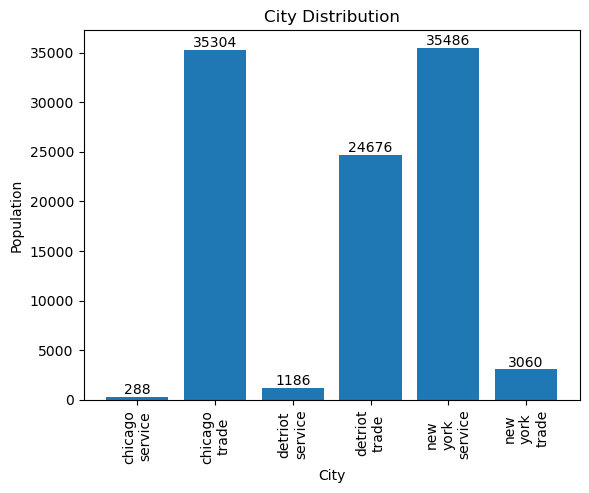

In [3]:
location_choice = {}

location_choice = get_location_choice(location_choice, shape, rho_values[0], df_trades, 50000)
location_choice = get_location_choice(location_choice, shape, rho_values[1], df_services, 50000)

new_location_choice = {(city_names[i] + "_" + ocupation_names[j]): location_choice[(i, j)] for (i, j) in location_choice.keys()}

print(new_location_choice)

plot_cities(new_location_choice, 'graphs/city_pop.png')

/tmp/ipykernel_23559/2735193616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades[('trade', 'detriot')] *= 0.5
/tmp/ipykernel_23559/2735193616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_services[('service', 'detriot')] *= 0.5
  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_23559/1567133130.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

{'new_york_service': 45087, 'chicago_trade': 44734, 'detriot_trade': 5602, 'new_york_trade': 3842, 'detriot_service': 375, 'chicago_service': 360}



/tmp/ipykernel_23559/1567133130.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


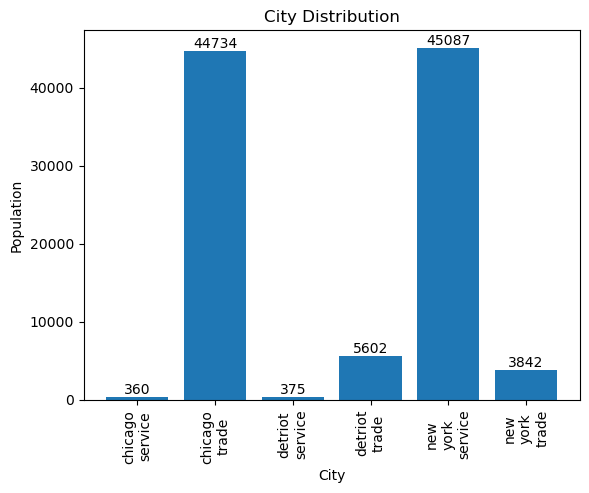

In [4]:
df_trades[('trade', 'detriot')] *= 0.5
df_services[('service', 'detriot')] *= 0.5

location_choice = {}

location_choice = get_location_choice(location_choice, shape, rho_values[0], df_trades, 50000)
location_choice = get_location_choice(location_choice, shape, rho_values[1], df_services, 50000)

new_location_choice = {(city_names[i] + "_" + ocupation_names[j]): location_choice[(i, j)] for (i, j) in location_choice.keys()}

print(new_location_choice)
plot_cities(new_location_choice, 'graphs/c_shock.png')